# EasyVVUQ fusion tutorial

Run an EasyVVUQ campaign to analyze the sensitivity of the temperature
profile predicted by a simplified model of heat conduction in a
tokamak plasma.

This is done with PCE.

In [1]:
# import packages that we will use

import os
import easyvvuq as uq
import chaospy as cp
import pickle
import time
import numpy as np 
import matplotlib.pylab as plt

In [2]:
# Set up a fresh campaign called "fusion_pce."

my_campaign = uq.Campaign(name='fusion_pce.')

In [3]:
# Define parameter space

params = {
    "Qe_tot":   {"type": "float",   "min": 1.0e6, "max": 50.0e6, "default": 2e6}, 
    "H0":       {"type": "float",   "min": 0.00,  "max": 1.0,    "default": 0}, 
    "Hw":       {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 0.1}, 
    "Te_bc":    {"type": "float",   "min": 10.0,  "max": 1000.0, "default": 100}, 
    "chi":      {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 1}, 
    "a0":       {"type": "float",   "min": 0.2,   "max": 10.0,   "default": 1}, 
    "R0":       {"type": "float",   "min": 0.5,   "max": 20.0,   "default": 3}, 
    "E0":       {"type": "float",   "min": 1.0,   "max": 10.0,   "default": 1.5}, 
    "b_pos":    {"type": "float",   "min": 0.95,  "max": 0.99,   "default": 0.98}, 
    "b_height": {"type": "float",   "min": 3e19,  "max": 10e19,  "default": 6e19}, 
    "b_sol":    {"type": "float",   "min": 2e18,  "max": 3e19,   "default": 2e19}, 
    "b_width":  {"type": "float",   "min": 0.005, "max": 0.025,  "default": 0.01}, 
    "b_slope":  {"type": "float",   "min": 0.0,   "max": 0.05,   "default": 0.01}, 
    "nr":       {"type": "integer", "min": 10,    "max": 1000,   "default": 100}, 
    "dt":       {"type": "float",   "min": 1e-3,  "max": 1e3,    "default": 100},
    "out_file": {"type": "string",  "default": "output.csv"}
}

In [4]:
# Create an encoder, decoder and collater for PCE test app

encoder = uq.encoders.GenericEncoder(template_fname='fusion.template',
                                     delimiter='$',
                                     target_filename='fusion_in.json')


decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                output_columns=["te", "ne", "rho", "rho_norm"],
                                header=0)

collater = uq.collate.AggregateSamples(average=False)

In [5]:
# Add the app (automatically set as current app)

my_campaign.add_app(name="fusion",
                    params=params,
                    encoder=encoder,
                    decoder=decoder,
                    collater=collater)

In [6]:
# Create the sampler (here simplified to two uncertain quantities)

vary = {
    "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
    "Te_bc":    cp.Uniform(80.0,  120.0)
}

""" other possible quantities to vary
    "H0":       cp.Uniform(0.0,   0.2),
    "Hw":       cp.Uniform(0.1,   0.5),
    "chi":      cp.Uniform(0.8,   1.2), 

    "a0":       cp.Uniform(0.9,   1.1), 
    "R0":       cp.Uniform(2.7,   3.3), 
    "E0":       cp.Uniform(1.4,   1.6), 
    "b_pos":    cp.Uniform(0.95,  0.99), 
    "b_height": cp.Uniform(5e19,  7e19), 
    "b_sol":    cp.Uniform(1e19,  3e19), 
    "b_width":  cp.Uniform(0.015, 0.025), 
    "b_slope":  cp.Uniform(0.005, 0.020)
"""

In [7]:
# Associate a sampler with the campaign

my_campaign.set_sampler(uq.sampling.PCESampler(vary=vary, polynomial_order=3))

In [8]:
# Will draw all (of the finite set of samples)

my_campaign.draw_samples()
print('Number of samples = %s' % my_campaign.get_active_sampler().count)

Number of samples = 25


In [9]:
# Create and populate the run directories

my_campaign.populate_runs_dir()

In [10]:
# Run the cases

cwd = os.getcwd().replace(' ', '\ ')      # deal with ' ' in the path
cmd = f"{cwd}/fusion_model.py fusion_in.json"
my_campaign.apply_for_each_run_dir(uq.actions.ExecuteLocal(cmd, interpret='python3'))

In [11]:
# Collate the results

my_campaign.collate()

In [12]:
# Post-processing analysis

my_campaign.apply_analysis(uq.analysis.PCEAnalysis(sampler=my_campaign.get_active_sampler(), 
                                                   qoi_cols=["te", "ne", "rho", "rho_norm"]))

In [13]:
# Get Descriptive Statistics

results = my_campaign.get_last_analysis()
stats = results['statistical_moments']['te']
per = results['percentiles']['te']
sobols = results['sobols_first']['te']
rho = results['statistical_moments']['rho']['mean']
rho_norm = results['statistical_moments']['rho_norm']['mean']

<IPython.core.display.Javascript object>


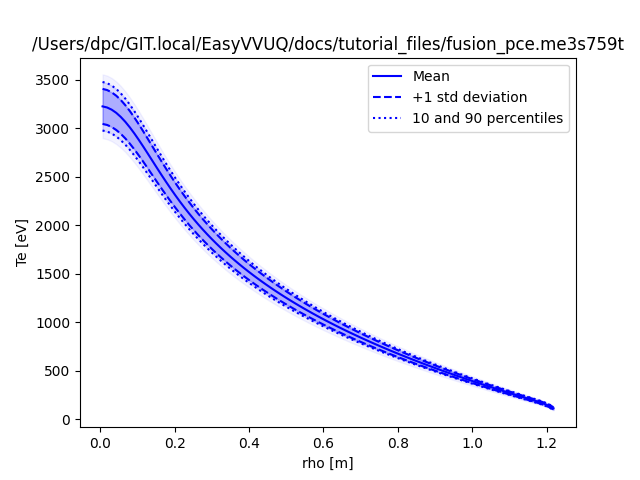

Text(0.5, 1.0, '/Users/dpc/GIT.local/EasyVVUQ/docs/tutorial_files/fusion_pce.me3s759t')

In [18]:
# plot the calculated Te: mean, with std deviation, 10 and 90% and range

%matplotlib notebook
plt.figure() 
plt.plot(rho, stats['mean'], 'b-', label='Mean')
plt.plot(rho, stats['mean']-stats['std'], 'b--', label='+1 std deviation')
plt.plot(rho, stats['mean']+stats['std'], 'b--')
plt.fill_between(rho, stats['mean']-stats['std'], stats['mean']+stats['std'], color='b', alpha=0.2)
plt.plot(rho, per['p10'].ravel(), 'b:', label='10 and 90 percentiles')
plt.plot(rho, per['p90'].ravel(), 'b:')
plt.fill_between(rho, per['p10'].ravel(), per['p90'].ravel(), color='b', alpha=0.1)
plt.fill_between(rho, [r.lower[0] for r in results['output_distributions']['te']], [r.upper[0] for r in results['output_distributions']['te']], color='b', alpha=0.05)
plt.legend(loc=0)
plt.xlabel('rho [m]')
plt.ylabel('Te [eV]')
plt.title(my_campaign.campaign_dir)

<IPython.core.display.Javascript object>


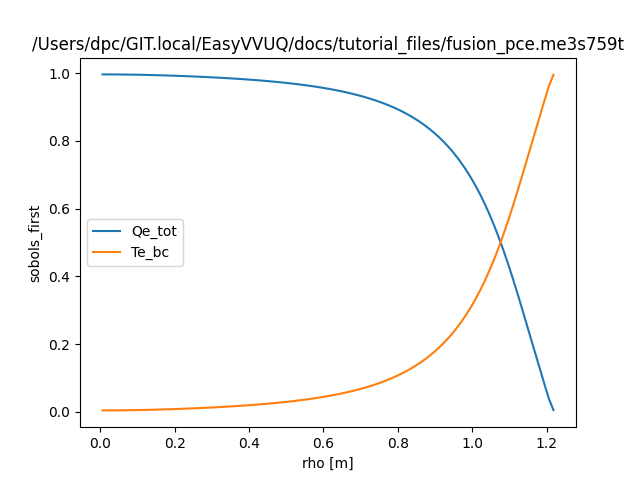

Text(0.5, 1.0, '/Users/dpc/GIT.local/EasyVVUQ/docs/tutorial_files/fusion_pce.me3s759t')

In [19]:
# plot the first Sobol results

%matplotlib notebook
plt.figure() 
for k in sobols.keys(): plt.plot(rho, sobols[k][0], label=k)
plt.legend(loc=0)
plt.xlabel('rho [m]')
plt.ylabel('sobols_first')
plt.title(my_campaign.campaign_dir)

<IPython.core.display.Javascript object>


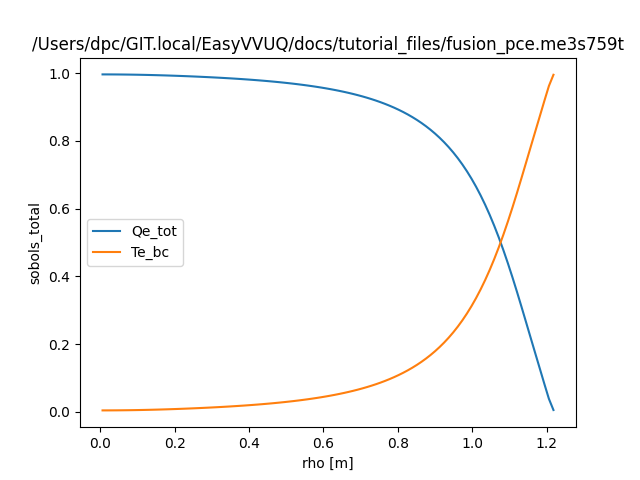

Text(0.5, 1.0, '/Users/dpc/GIT.local/EasyVVUQ/docs/tutorial_files/fusion_pce.me3s759t')

In [20]:
# plot the total Sobol results

%matplotlib notebook
plt.figure() 
for k in results['sobols_total']['te'].keys(): plt.plot(rho, results['sobols_total']['te'][k][0], label=k)
plt.legend(loc=0)    
plt.xlabel('rho [m]')
plt.ylabel('sobols_total')
plt.title(my_campaign.campaign_dir)

<IPython.core.display.Javascript object>


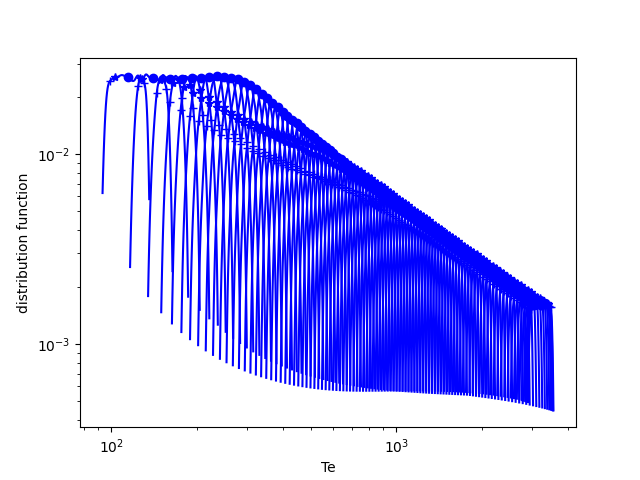

Text(0, 0.5, 'distribution function')

In [17]:
# plot the distributions

%matplotlib notebook

for i, D in enumerate(results['output_distributions']['te']):
    _Te = np.linspace(D.lower[0], D.upper[0], 101)
    _DF = D.pdf(_Te)
    plt.loglog(_Te, _DF, 'b-')
    plt.loglog(stats['mean'][i], np.interp(stats['mean'][i], _Te, _DF), 'bo')
    plt.loglog(stats['mean'][i]-stats['std'][i], np.interp(stats['mean'][i]-stats['std'][i], _Te, _DF), 'b*')
    plt.loglog(stats['mean'][i]+stats['std'][i], np.interp(stats['mean'][i]+stats['std'][i], _Te, _DF), 'b*')
    plt.loglog(per['p10'].ravel()[i],  np.interp(per['p10'].ravel()[i], _Te, _DF), 'b+')
    plt.loglog(per['p90'].ravel()[i],  np.interp(per['p90'].ravel()[i], _Te, _DF), 'b+')
plt.xlabel('Te')
plt.ylabel('distribution function')